In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import tensorflow as tf

In [2]:
# 打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp() % (24 * 60 * 60)

    hour = tf.cast(today_ts // 3600 + 8, tf.int32) % tf.constant(24)
    minite = tf.cast((today_ts % 3600) // 60, tf.int32)
    second = tf.cast(tf.floor(today_ts % 60), tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}", m)) == 1:
            return(tf.strings.format("0{}", m))
        else:
            return(tf.strings.format("{}", m))
    
    timestring = tf.strings.join([timeformat(hour), timeformat(minite), 
                timeformat(second)], separator=":")
    tf.print("==========" * 8 + timestring)

In [3]:
# 样本数量
n = 400

# 生成测试用数据集
X = tf.random.uniform([n, 2], minval=-10, maxval=10) 
w0 = tf.constant([[1.5], [-2.5]])
b0 = tf.constant([[3.0]])
Y = X @ w0 + b0 + tf.random.normal([n, 1], mean=0.0, stddev=2)  # 增加正态扰动

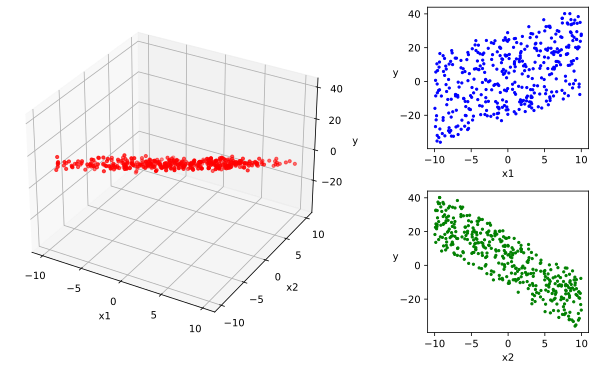

In [4]:
# 数据可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12, 6))
plt.subplots_adjust(wspace=0.05, hspace=0.3)
ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan=2, colspan=3, projection="3d")
ax1.scatter3D(X[:, 0], X[:, 1], Y[:, 0], c="r", s=10)
ax1.xaxis.set_major_locator(MultipleLocator(5))
ax1.yaxis.set_major_locator(MultipleLocator(5))
ax1.zaxis.set_major_locator(MultipleLocator(20))
ax1.xaxis.set_label_text("x1")
ax1.yaxis.set_label_text("x2")
ax1.zaxis.set_label_text("y")


ax2 = plt.subplot2grid((2, 4), (0, 3), rowspan=1, colspan=1)
ax2.scatter(X[:, 0], Y, c="b", s=5)
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

ax3 = plt.subplot2grid((2, 4), (1, 3), rowspan=1, colspan=1)
ax3.scatter(X[:, 1], Y, c="g", s=5)
plt.xlabel("x2")
plt.ylabel("y", rotation=0)

# plt.savefig("figs/3-6-regression-data-visualization.svg")
plt.show()

In [5]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)      # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i + batch_size, num_examples)]
        yield tf.gather(features, indexs), tf.gather(labels, indexs)
        
# 测试数据管道效果
batch_size = 8
(features, labels) = next(data_iter(X, Y, batch_size))
print(features)
print(labels)

tf.Tensor(
[[-3.7026286  7.497341 ]
 [ 8.601513  -6.341939 ]
 [-9.317682  -8.789463 ]
 [-6.837256   1.3155079]
 [-1.6674328  5.509384 ]
 [ 4.6137123  9.613487 ]
 [ 9.585205  -6.903529 ]
 [-5.386765   7.5304565]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[-19.638344 ]
 [ 33.591118 ]
 [ 11.49909  ]
 [ -8.270405 ]
 [-11.891282 ]
 [-15.7080345]
 [ 38.38127  ]
 [-24.462807 ]], shape=(8, 1), dtype=float32)


In [6]:
w = tf.Variable(tf.random.normal(w0.shape))
b = tf.Variable(tf.zeros_like(b0, dtype=tf.float32))

# 定义模型
class LinearRegression:     
    # 正向传播
    def __call__(self, x): 
        return x @ w + b

    # 损失函数
    def loss_func(self, y_true, y_pred):  
        return tf.reduce_mean((y_true - y_pred) ** 2 / 2)

model = LinearRegression()

In [7]:
# 使用动态图调试
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
    # 反向传播求梯度
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
    # 梯度下降法更新参数
    w.assign(w - 0.001 * dloss_dw)
    b.assign(b - 0.001 * dloss_db)
    
    return loss

In [8]:
# 测试 train_step 效果
batch_size = 10
(features, labels) = next(data_iter(X, Y, batch_size))
train_step(model, features, labels)

<tf.Tensor: shape=(), dtype=float32, numpy=81.346924>

In [9]:
def train_model(model, epochs):
    for epoch in tf.range(1, epochs + 1):
        for features, labels in data_iter(X, Y, 10):
            loss = train_step(model, features, labels)

        if epoch % 50 == 0:
            printbar()
            tf.print("epoch =", epoch, "loss = ", loss)
            tf.print("w =", w)
            tf.print("b =", b)

train_model(model, epochs=200)

================================================================================15:32:02
epoch = 50 loss =  1.1028949
w = [[1.4894284]
 [-2.4998188]]
b = [[2.59044409]]
================================================================================15:32:05
epoch = 100 loss =  1.2159102
w = [[1.48450553]
 [-2.50423431]]
b = [[2.93911624]]
================================================================================15:32:09
epoch = 150 loss =  2.0248723
w = [[1.47757041]
 [-2.50146389]]
b = [[2.98621416]]
================================================================================15:32:13
epoch = 200 loss =  1.82429087
w = [[1.47493804]
 [-2.50053453]]
b = [[2.99293947]]


In [10]:
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
    # 反向传播求梯度
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
    # 梯度下降法更新参数
    w.assign(w - 0.001 * dloss_dw)
    b.assign(b - 0.001 * dloss_db)
    
    return loss

def train_model(model,epochs):
    for epoch in tf.range(1, epochs + 1):
        for features, labels in data_iter(X, Y, 10):
            loss = train_step(model, features, labels)
        if epoch % 50 == 0:
            printbar()
            tf.print("epoch =", epoch, "loss = ", loss)
            tf.print("w =", w)
            tf.print("b =", b)

train_model(model, epochs=200)

================================================================================15:32:14
epoch = 50 loss =  1.04857028
w = [[1.4928062]
 [-2.50889874]]
b = [[2.99413133]]
================================================================================15:32:15
epoch = 100 loss =  1.36922872
w = [[1.48708379]
 [-2.50392199]]
b = [[2.99404573]]
================================================================================15:32:16
epoch = 150 loss =  1.96865559
w = [[1.48904729]
 [-2.49720168]]
b = [[2.99380922]]
================================================================================15:32:17
epoch = 200 loss =  2.9025712
w = [[1.47942281]
 [-2.50786138]]
b = [[2.99378419]]


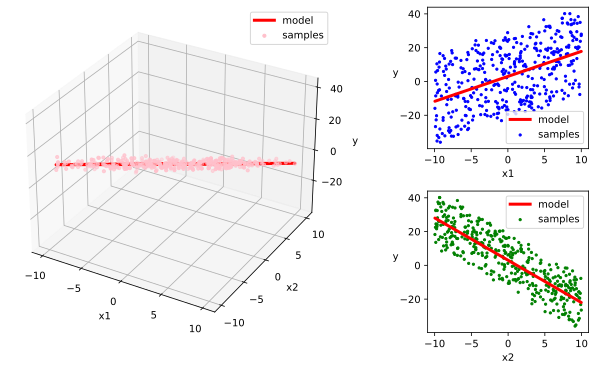

In [11]:
# 结果可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12, 6))
plt.subplots_adjust(wspace=0.05, hspace=0.3)
ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan=2, colspan=3, projection="3d")
ax1.scatter3D(X[:, 0], X[:, 1], Y[:, 0], c="pink", s=10, label="samples")
ax1.plot3D(X[:, 0], X[:, 1], 
           w[0] * X[:, 0] + w[1] * X[:, 1] + b[0], "-r", linewidth=3.0, label="model")
ax1.xaxis.set_major_locator(MultipleLocator(5))
ax1.yaxis.set_major_locator(MultipleLocator(5))
ax1.zaxis.set_major_locator(MultipleLocator(20))
ax1.xaxis.set_label_text("x1")
ax1.yaxis.set_label_text("x2")
ax1.zaxis.set_label_text("y")
ax1.legend()

ax2 = plt.subplot2grid((2, 4), (0, 3), rowspan=1, colspan=1)
ax2.scatter(X[:, 0], Y, c="b", s=5, label="samples")
ax2.plot(X[:, 0], w[0] * X[:, 0] + b[0], "-r", linewidth=3.0, label="model")
ax2.legend()
plt.xlabel("x1")
plt.ylabel("y", rotation=0)


ax3 = plt.subplot2grid((2, 4), (1, 3), rowspan=1, colspan=1)
ax3.scatter(X[:, 1], Y, c="g", s=5, label="samples")
ax3.plot(X[:, 1], w[1] * X[:, 1] + b[0], "-r", linewidth=3.0, label="model")
ax3.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation=0)
# plt.savefig("figs/3-6-visualization-of-regression-results.svg")
plt.show()

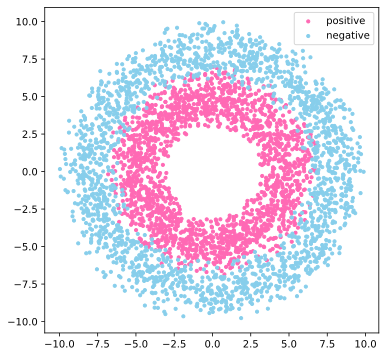

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 正负样本数量
n_positive, n_negative = 2000, 2000

# 生成正样本, 小圆环分布
r_p = 5.0 + tf.random.truncated_normal([n_positive, 1], 0.0, 1.0)
theta_p = tf.random.uniform([n_positive, 1], 0.0, 2 * np.pi) 
Xp = tf.concat([r_p * tf.cos(theta_p), r_p * tf.sin(theta_p)], axis=1)
Yp = tf.ones_like(r_p)

# 生成负样本, 大圆环分布
r_n = 8.0 + tf.random.truncated_normal([n_negative, 1], 0.0, 1.0)
theta_n = tf.random.uniform([n_negative, 1], 0.0, 2 * np.pi) 
Xn = tf.concat([r_n * tf.cos(theta_n), r_n * tf.sin(theta_n)], axis=1)
Yn = tf.zeros_like(r_n)

# 汇总样本
X = tf.concat([Xp, Xn], axis=0)
Y = tf.concat([Yp, Yn], axis=0)

# 可视化
plt.figure(figsize=(6, 6))
plt.scatter(Xp[:, 0].numpy(), Xp[:, 1].numpy(), c="hotpink", s=10)
plt.scatter(Xn[:, 0].numpy(), Xn[:, 1].numpy(), c="skyblue", s=10)
plt.legend(["positive", "negative"])
# plt.savefig("figs/3-6-categorical-data-visualization.svg")

In [13]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)      # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i + batch_size, num_examples)]
        yield tf.gather(features, indexs), tf.gather(labels, indexs)
        
# 测试数据管道效果   
batch_size = 10
(features, labels) = next(data_iter(X, Y, batch_size))
print(features)
print(labels)

tf.Tensor(
[[-3.3034627   6.97388   ]
 [-5.123651   -1.6873623 ]
 [ 4.4933553   0.27742022]
 [ 6.340078   -6.819982  ]
 [-3.430853   -2.6209564 ]
 [-3.1646385   1.5006043 ]
 [-2.4258964  -3.7886536 ]
 [-0.38687602  4.5730095 ]
 [-4.4283056   3.149475  ]
 [ 6.225599   -5.568595  ]], shape=(10, 2), dtype=float32)
tf.Tensor(
[[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]], shape=(10, 1), dtype=float32)


In [14]:
class DNNModel(tf.Module):
    def __init__(self, name=None):
        super(DNNModel, self).__init__(name=name)
        self.w1 = tf.Variable(tf.random.truncated_normal([2, 4]), dtype=tf.float32)
        self.b1 = tf.Variable(tf.zeros([1, 4]), dtype=tf.float32)
        self.w2 = tf.Variable(tf.random.truncated_normal([4, 8]), dtype=tf.float32)
        self.b2 = tf.Variable(tf.zeros([1, 8]), dtype=tf.float32)
        self.w3 = tf.Variable(tf.random.truncated_normal([8, 1]), dtype=tf.float32)
        self.b3 = tf.Variable(tf.zeros([1, 1]), dtype=tf.float32)

    # 正向传播
    @tf.function(
        input_signature=[tf.TensorSpec(shape=[None, 2], dtype=tf.float32)],
        experimental_relax_shapes=True
    )  
    def __call__(self, x):
        x = tf.nn.relu(x @ self.w1 + self.b1)
        x = tf.nn.relu(x @ self.w2 + self.b2)
        y = tf.nn.sigmoid(x @ self.w3 + self.b3)
        return y

    # 损失函数（二元交叉熵）
    @tf.function(
        input_signature=[
            tf.TensorSpec(shape=[None, 1], dtype=tf.float32), 
            tf.TensorSpec(shape=[None, 1], dtype=tf.float32)
        ],
        experimental_relax_shapes=True
    )  
    def loss_func(self, y_true, y_pred):
        # 将预测值限制在 1e-7 以上, 1 - 1e-7 以下，避免 log(0) 错误
        eps = 1e-7
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        bce = - y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        return  tf.reduce_mean(bce)

    # 评估指标（准确率）
    @tf.function(
        input_signature=[
            tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
            tf.TensorSpec(shape=[None, 1], dtype=tf.float32)
        ],
        experimental_relax_shapes=True
    ) 
    def metric_func(self, y_true, y_pred):
        y_pred = tf.where(y_pred > 0.5, tf.ones_like(y_pred, dtype=tf.float32),
                          tf.zeros_like(y_pred, dtype=tf.float32))
        acc = tf.reduce_mean(1 - tf.abs(y_true - y_pred))
        return acc

model = DNNModel()

In [15]:
batch_size = 10
(features, labels) = next(data_iter(X, Y, batch_size))

predictions = model(features)

loss = model.loss_func(labels, predictions)
metric = model.metric_func(labels, predictions)

tf.print("init loss:", loss)
tf.print("init metric", metric)

init loss: 0.921482921
init metric 0.6


In [16]:
print(len(model.trainable_variables))

6


In [17]:
## 使用 autograph 机制转换成静态图加速
@tf.function
def train_step(model, features, labels):

    # 正向传播求损失
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions) 

    # 反向传播求梯度
    grads = tape.gradient(loss, model.trainable_variables)

    # 执行梯度下降
    for p, dloss_dp in zip(model.trainable_variables, grads):
        p.assign(p - 0.001 * dloss_dp)

    # 计算评估指标
    metric = model.metric_func(labels, predictions)

    return loss, metric


def train_model(model, epochs):
    for epoch in tf.range(1, epochs+1):
        for features, labels in data_iter(X, Y, 100):
            loss, metric = train_step(model, features, labels)
        if epoch % 100 == 0:
            printbar()
            tf.print(
                "epoch = " + tf.as_string(epoch)
                + ", loss = " + tf.as_string(loss)
                + ", accuracy = " + tf.as_string(metric)
            )

train_model(model, epochs=1000)

================================================================================15:32:22
epoch = 100, loss = 0.543990, accuracy = 0.770000
================================================================================15:32:25
epoch = 200, loss = 0.480271, accuracy = 0.780000
================================================================================15:32:29
epoch = 300, loss = 0.436533, accuracy = 0.760000
================================================================================15:32:32
epoch = 400, loss = 0.368662, accuracy = 0.890000
================================================================================15:32:35
epoch = 500, loss = 0.221828, accuracy = 0.920000
================================================================================15:32:38
epoch = 600, loss = 0.115654, accuracy = 0.980000
================================================================================15:32:41
epoch = 700, loss = 0.121260, accuracy = 0.970000
===========================

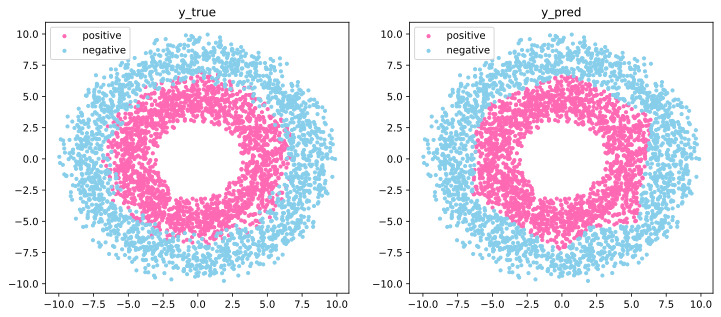

In [20]:
# 结果可视化
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax1.scatter(Xp[:, 0], Xp[:, 1], c="hotpink", s=10)
ax1.scatter(Xn[:, 0], Xn[:, 1], c="skyblue", s=10)
ax1.legend(["positive", "negative"])
ax1.set_title("y_true")

Xp_pred = tf.boolean_mask(X, tf.squeeze(model(X) >= 0.5), axis=0)
Xn_pred = tf.boolean_mask(X, tf.squeeze(model(X) < 0.5), axis=0)

ax2.scatter(Xp_pred[:, 0], Xp_pred[:, 1], c="hotpink", s=10)
ax2.scatter(Xn_pred[:, 0], Xn_pred[:, 1], c="skyblue", s=10)
ax2.legend(["positive", "negative"])
ax2.set_title("y_pred")
# fig.savefig("figs/3-6-classification-results-visualization.svg")